# loadest-gp
LOAD ESTimator (LOADEST) is a software program for estimating some constituent using surrogate variables (covariates).
However, LOADEST has several serious limitations, and it has been all but replaced by another model known as WRTDS.
`loadest-gp` essentially reimplements WRTDS as a Gaussian process.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/discontinuum/blob/main/notebooks/loadest-gp-demo.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/thodson-usgs/discontinuum/main?labpath=notebooks%2Floadest-gp-demo.ipynb)

In [2]:
#setup colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   os.system('pip install pymc dataretrieval')
   os.system('MKL_THREADING_LAYER=GNU')

In [106]:
import matplotlib.pyplot as plt
import xarray as xr

from loadest_gp.providers import usgs
from discontinuum.utils import aggregate_to_daily

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# setup

# Choptank River at Greensboro, MD
#site = "01491000" 
#start_date = "1979-10-01"
#end_date = "2011-09-30"

# SF Coeur D Alene River 
site = "12413470"
start_date = "1988-10-01" 
end_date = "2021-09-30" 

characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
#characteristic = 'Phosphorus'
fraction = 'Dissolved'

In [108]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


In [109]:
%%time
# fit model

from loadest_gp import LoadestGP

model = LoadestGP()
model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:01:36 logp = -149.56, ||grad|| = 0.20105

CPU times: user 6.06 s, sys: 1.04 s, total: 7.1 s
Wall time: 4.76 s


Text(0.5, 0, 'Year')

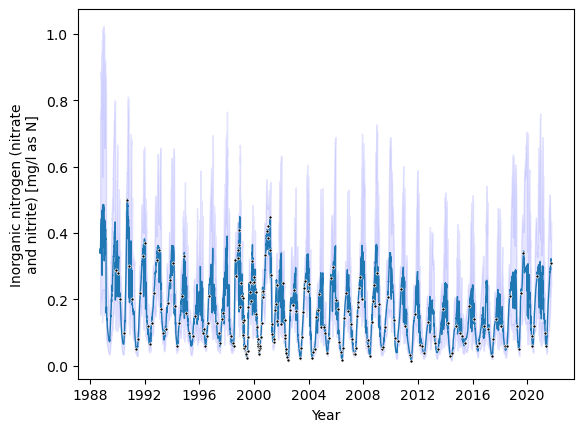

In [118]:
# plot result
fig, ax = plt.subplots()
model.plot(daily[['time','flow']], ax=ax)
ax.set_xlabel('Year')

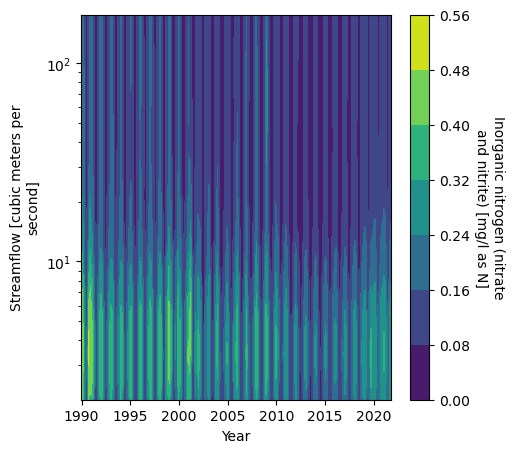

In [111]:
#  plot
model.contourf(levels=5)
plt.show()

In [112]:
# simulate concentration
sim_slice = daily[['time','flow']].sel(time=slice("1990","2020"))

sim = model.sample(sim_slice)

In [113]:
# simulate flux
def to_flux(concentration, flow):
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs['units'] = 'kilograms per day'
    flux.attrs['standard_name'] = 'flux'
    return flux

In [114]:
import matplotlib.pyplot as plt

def plot_annual_sum(sim):
    """Describe
    """
    fig, ax = plt.subplots()
    annual = sim.resample(time='YE').sum()
    annual.attrs['units'] = 'kilograms per year'
    annual.attrs['short_name'] = 'flux'
    
    annual.to_dataframe(name=annual.attrs['short_name']).boxplot(by='time', showfliers=False, grid=False, ax=ax)
    ax.set_ylabel('{}\n[{}]'.format(annual.attrs['long_name'], annual.attrs['units']))
    ax.set_xlabel('Year')
    ax.tick_params(axis='x', labelrotation=90)

    labels = ['' if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title('')
    #fig.suptitle('')
    return ax

In [ ]:
flux = to_flux(sim, sim_slice['flow'])
plot_annual_sum(flux)

In [ ]:
# now let's create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005","2005"))

In [ ]:
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice['flow'])

In [ ]:
plot_annual_sum(counterfactual_sim)